In [3]:
import numpy as np
from scipy.linalg import expm


def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    if not (0 <= f <= 1):
        raise ValueError("Fraction f must be between 0 and 1.")
    theta = 2.0 * np.arcsin(np.sqrt(f))
    # print(theta)
    return theta / Omega if Omega != 0 else 0.0

def simulate_sequence(init_state,couplings, rabi_freqs, fractions,
                      fixed_phase_flags,
                      dim=4):
    state = init_state
    for (levels, Omega, frac, fix_pflag) in zip(
        couplings, rabi_freqs, fractions,
        fixed_phase_flags,
    ):
        i, j = levels

        phi_fixed = fix_pflag * 1

        total_phase = phi_fixed 

        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op

        t_pulse = pulse_duration_for_fraction(frac, Omega)  
        
        # Evolve the state
        U = expm(-1j * H_coupling * t_pulse)  # e^{-i H t}
        state = U @ state
        print(state)
    return state

dim = 4
init_state = np.zeros(dim, dtype=complex)
init_state[0] = 1.0

couplings = [(0,1),(0,2),(0,3)]
fractions = [1/4,1/3,1/2]
rabi_freqs = [1,1,1]
fixed_phase_flags =  [0,0,0]
print(simulate_sequence(init_state,couplings,rabi_freqs,fractions,fixed_phase_flags,dim))

[0.8660254+0.j  0.       -0.5j 0.       +0.j  0.       +0.j ]
[0.70710678+0.j  0.        -0.5j 0.        -0.5j 0.        +0.j ]
[0.5+0.j  0. -0.5j 0. -0.5j 0. -0.5j]
[0.5+0.j  0. -0.5j 0. -0.5j 0. -0.5j]


In [5]:
import numpy as np
from scipy.linalg import expm

def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    if not (0 <= f <= 1):
        raise ValueError("Fraction f must be between 0 and 1.")
    theta = 2.0 * np.arcsin(np.sqrt(f))
    return theta / Omega if Omega != 0 else 0.0

def equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):

    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * 1
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def bv_oracle(dim=4, hidden_string="10"):

    oracle = np.eye(dim, dtype=complex)
    if hidden_string == "10":
        oracle[2, 2] = -1
        oracle[3, 3] = -1
    return oracle

dim = 4

init_state = np.zeros(dim, dtype=complex)
init_state[1] = 1.0

couplings = [(0, 1), (0, 2), (0, 3)]
fractions = [1/4, 1/3, 1/2]  
rabi_freqs = [1, 1, 1]      
fixed_phase_flags = [-0.5, -0.5, -0.5]        

couplings = [(0, 1), (0, 2), (0, 3)]
fractions = [1/4, 1/3, 1/2]  
rabi_freqs = [1, 1, 1]      
fixed_phase_flags = [-0.5, -0.5, -0.5]        

U1 = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)

state_super = U1 @ init_state
print("State after equal superposition (U_seq applied):")
for idx, amplitude in enumerate(state_super):
    print(f"  |{idx:02b}>: {np.round(amplitude,3)}")
print("-----")

U_oracle = bv_oracle(dim, hidden_string="10")
state_oracle = U_oracle @ state_super
print("State after applying BV oracle:")
for idx, amplitude in enumerate(state_oracle):
    print(f"  |{idx:02b}>: {np.round(amplitude,3)}")
print("-----")

couplings = [(0, 3), (0, 2), (0, 1)]
fractions = [1/2, 1/3, 1/4]  
rabi_freqs = [1, 1, 1]      
fixed_phase_flags = [-0.5, -0.5, -0.5]  


U2 = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)

state_final = U2 @ state_oracle
print("Final state after applying reverse (U_seq†):")
for idx, amplitude in enumerate(state_final):
    print(f"  |{idx:02b}>: {np.round(amplitude,3)}")


State after equal superposition (U_seq applied):
  |00>: (-0.138-0.253j)
  |01>: (0.866-0j)
  |10>: (-0.289-0j)
  |11>: (-0.289+0j)
-----
State after applying BV oracle:
  |00>: (-0.138-0.253j)
  |01>: (0.866-0j)
  |10>: (0.289+0j)
  |11>: (0.289-0j)
-----
Final state after applying reverse (U_seq†):
  |00>: (-0.415-0.76j)
  |01>: (0.5-0j)
  |10>: 0j
  |11>: -0j


In [7]:
import numpy as np

def bv_oracle_general(dim, hidden_string):

    n = int(np.log2(dim))
    if len(hidden_string) != n:
        raise ValueError("hidden_string must have length log2(dim)")

    s_bits = [int(bit) for bit in hidden_string]

    oracle = np.eye(dim, dtype=complex)

    for x in range(dim):

        x_bits = [int(b) for b in format(x, f'0{n}b')]
        dot_product = sum(s * b for s, b in zip(s_bits, x_bits)) % 2

        if dot_product == 1:
            oracle[x, x] = -1
    return oracle

oracle = bv_oracle_general(4, "10")
print("BV Oracle for hidden string '10':")
print(oracle)

oracle_8 = bv_oracle_general(8, "101")
print("\nBV Oracle for hidden string '101':")
print(oracle_8)


BV Oracle for hidden string '10':
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]

BV Oracle for hidden string '101':
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


In [9]:
import numpy as np

def givens_rotation(dim, i, j, theta, phi):

    U = np.eye(dim, dtype=complex)
    c = np.cos(theta)
    s = np.sin(theta)
    U[i, i] = c
    U[j, j] = c
    U[i, j] = -np.exp(1j * phi) * s
    U[j, i] = np.exp(-1j * phi) * s
    return U

def polyqubit_hadamard(dim=4):

    U = np.eye(dim, dtype=complex)

    U1 = givens_rotation(dim, 0, 1, 1/8, 1)
    
    # U2 = givens_rotation(dim, 2, 3, 1/4, 1)
    U = U1 @ U

    # U3 = givens_rotation(dim, 0, 2, 1/4, 1)
    # U4 = givens_rotation(dim, 1, 3, 1/4, 1)
    # U = U4 @ U3 @ U
    return U

def main():
    dim = 4
    # Create the poly-qubit Hadamard operator.
    H_poly = polyqubit_hadamard(dim)
    
    # For reference, build the ideal H⊗H (up to a global factor)
    H_single = (1/np.sqrt(2)) * np.array([[1, 1],
                                           [1, -1]])
    H_ideal = np.kron(H_single, H_single)
    
    np.set_printoptions(precision=3, suppress=True)
    print("Decomposed poly-qubit Hadamard (up to global phase):")
    print(np.round(H_poly,3))
    print("\nIdeal H ⊗ H:")
    print(np.round(H_ideal,3))

if __name__ == '__main__':
    main()


Decomposed poly-qubit Hadamard (up to global phase):
[[ 0.992+0.j    -0.067-0.105j  0.   +0.j     0.   +0.j   ]
 [ 0.067-0.105j  0.992+0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     1.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     1.   +0.j   ]]

Ideal H ⊗ H:
[[ 0.5  0.5  0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]]


In [13]:
def givens_rotation(dim, i, j, theta, phi):

    U = np.eye(dim, dtype=complex)
    c = np.cos(theta)
    s = np.sin(theta)
    U[i, i] = c
    U[j, j] = c
    U[i, j] = -np.exp(1j * phi) * s
    U[j, i] = np.exp(-1j * phi) * s
    return U

givens_rotation(2,0,1,1/4,-1)@np.array([1,0])

array([0.969+0.j   , 0.134+0.208j])

In [15]:
def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    # if not (0 <= f <= 1):
    #     raise ValueError("Fraction f must be between 0 and 1.")
    theta = f#2.0 * np.arcsin(np.sqrt(f))
    return theta / Omega if Omega != 0 else 0.0

def equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):

    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * 1
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

dim =2 
init_state = np.array([np.sqrt(3/4),np.sqrt(1/4)])
couplings = [(0, 1)]
fractions = [1]#[np.sin(1)**2]  
rabi_freqs = [1]      
fixed_phase_flags = [0]        

U1 = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print(U1)
print('________________________')
print(U1@init_state)

[[0.878+0.j    0.   -0.479j]
 [0.   -0.479j 0.878+0.j   ]]
________________________
[0.76 -0.24j  0.439-0.415j]


In [17]:
import numpy as np
from scipy.linalg import expm

def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    # Here, we interpret the input 'f' directly as the rotation angle (theta)
    theta = f
    return theta / Omega if Omega != 0 else 0.0

def equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        # total_phase = fixed_phase_flag * π; setting fixed_phase_flag = -0.5 gives -π/2.
        phi_fixed = fixp = fix_pflag * 1  
        total_phase = phi_fixed
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

# Define parameters for a qubit (dim=2)
dim = 2
# Only one coupling is needed between levels 0 and 1.
couplings = [(0, 1)]
rabi_freqs = [1]           # Using an arbitrary Rabi frequency (in rad/unit time).
# To get a rotation angle of π/2, set the "fraction" to π/2.
fractions = [1/2]
# To implement a rotation about Y (i.e. R_y(π/2)), we choose a phase of -π/2.
# Since our code sets total_phase = fixed_phase_flag * π, we set fixed_phase_flag = -0.5.
fixed_phase_flags = [-0.5]

# Construct the simulated Hadamard (via R_y(π/2)) unitary.
H_unitary = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)

print("Simulated Hadamard unitary (up to a global phase):")
print(H_unitary)

# Apply the unitary to the initial state |0> = [1, 0].
init_state = np.array([0, 1], dtype=complex)
output_state = H_unitary @ init_state
print("\nOutput state when applied to |0>:")
print(output_state)

# For comparison, construct the ideal Hadamard matrix (up to a global phase).
H_ideal = (1/np.sqrt(2)) * np.array([[1,  1],
                                      [1, -1]])
print("\nIdeal Hadamard matrix:")
print(H_ideal)
print("\nIdeal output state for |0> (up to global phase):")
print(H_ideal @ init_state)


Simulated Hadamard unitary (up to a global phase):
[[ 0.969+0.j    -0.119-0.217j]
 [ 0.119-0.217j  0.969+0.j   ]]

Output state when applied to |0>:
[-0.119-0.217j  0.969+0.j   ]

Ideal Hadamard matrix:
[[ 0.707  0.707]
 [ 0.707 -0.707]]

Ideal output state for |0> (up to global phase):
[ 0.707+0.j -0.707+0.j]


In [19]:
import numpy as np
from scipy.linalg import expm

def coupling_operator_with_phase(i, j, dim, phi):
    """
    Constructs the coupling operator between levels i and j with phase phi.
    """
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    """
    Here 'f' is interpreted as the desired rotation angle (theta).
    """
    theta = f  # directly interpret f as the rotation angle (in radians)
    return theta / Omega if Omega != 0 else 0.0

def equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    """
    Constructs a unitary from a sequence of pulses.
    
    Each pulse is characterized by:
      - levels: a tuple (i,j) of coupled levels.
      - Omega: the Rabi frequency.
      - fraction (here interpreted as the rotation angle).
      - fixed_phase_flag: multiplied by π to give the phase.
      
    The overall unitary is the product of the pulse unitaries.
    """
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        # fixed phase: here fixed_phase_flag * π
        phi_fixed = fix_pflag * 1  
        total_phase = phi_fixed
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def qubit_hadamard_unitary(Omega=1):
    """
    Constructs an exact Hadamard gate for a qubit using a two-pulse approach.
    
    Step 1:
      - Use a pulse to implement R_y(π/2):
        U_y = exp(-i (π/4) σ_y)
      with the following parameters:
        - coupling between levels (0,1)
        - rotation angle: π/2 (i.e. fraction = π/2)
        - fixed_phase_flag = -0.5, so total_phase = -π/2.
      This pulse yields:
        U_y = (1/√2) [[1, -1],
                      [1,  1]].
    
    Step 2:
      - Apply a Z gate on the right: Z = diag(1, -1).
      Then the overall operation is:
         H = U_y · Z = (1/√2)[[1, 1],
                               [1, -1]]
      which is the standard Hadamard.
    """
    dim = 2
    # Define the pulse parameters for the R_y(π/2) pulse.
    couplings = [(0, 1)]
    # Set the rotation angle to π/2.
    fractions = [1/2]
    # Rabi frequency (choose Omega, e.g., 1 rad/unit time).
    rabi_freqs = [Omega]
    # fixed_phase_flag = -0.5 gives a phase of -π/2 so that the coupling operator becomes σ_y.
    fixed_phase_flags = [-0.5]
    
    # Build the unitary for the R_y(π/2) pulse.
    U_y = equal_superposition_unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
    
    # Define the Z gate.
    Z_gate = np.array([[1, 0],
                       [0, -1]], dtype=complex)
    
    # Compose them to yield the Hadamard.
    H_exact = U_y @ Z_gate
    return H_exact

def main():
    # Build the exact Hadamard gate using the pulse sequence.
    H_sim = qubit_hadamard_unitary(Omega=1)
    
    print("Simulated Hadamard unitary (exact):")
    print(H_sim)
    print("")
    
    # Ideal Hadamard (up to a global phase).
    H_ideal = (1/np.sqrt(2)) * np.array([[1,  1],
                                         [1, -1]], dtype=complex)
    print("Ideal Hadamard unitary:")
    print(H_ideal)
    print("")
    
    # Test on the computational basis states.
    basis_states = [np.array([1, 0], dtype=complex), np.array([0, 1], dtype=complex)]
    for idx, state in enumerate(basis_states):
        output_sim = H_sim @ state
        output_ideal = H_ideal @ state
        print(f"Input state |{idx}>:")
        print("Simulated output:", output_sim)
        print("Ideal output:    ", output_ideal)
        print("---------")
    
if __name__ == '__main__':
    main()


Simulated Hadamard unitary (exact):
[[ 0.969+0.j     0.119+0.217j]
 [ 0.119-0.217j -0.969-0.j   ]]

Ideal Hadamard unitary:
[[ 0.707+0.j  0.707+0.j]
 [ 0.707+0.j -0.707+0.j]]

Input state |0>:
Simulated output: [0.969+0.j    0.119-0.217j]
Ideal output:     [0.707+0.j 0.707+0.j]
---------
Input state |1>:
Simulated output: [ 0.119+0.217j -0.969-0.j   ]
Ideal output:     [ 0.707+0.j -0.707+0.j]
---------


In [21]:
import numpy as np
from scipy.linalg import expm

def coupling_operator_with_phase(i, j, dim, phi):
    """
    Constructs the coupling operator between levels i and j with an applied phase phi.
    """
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(angle, Omega):
    """
    Here, 'angle' is interpreted directly as the rotation angle (in radians).
    The pulse duration is t = angle / Omega.
    """
    return angle / Omega if Omega != 0 else 0.0

def pulse_unitary(angle, Omega, fixed_phase_flag, dim=2, coupling=(0,1)):
    """
    Constructs a unitary for a pulse on a two-level system.
    
    Parameters:
      - angle: the rotation angle in radians.
      - Omega: the Rabi frequency.
      - fixed_phase_flag: multiplied by π gives the phase (so a value of 0 means 0 phase,
        while -0.5 gives -π/2, which is useful for R_y rotations).
      - dim: dimension of the Hilbert space (default is 2 for a qubit).
      - coupling: a tuple indicating the two levels to couple (default is (0,1)).
    """
    phi = fixed_phase_flag * 1
    H_op = coupling_operator_with_phase(coupling[0], coupling[1], dim, phi)
    H_coupling = 0.5 * Omega * H_op
    t_pulse = pulse_duration_for_fraction(angle, Omega)
    U = expm(-1j * H_coupling * t_pulse)
    return U

def z_gate_from_givens(Omega=1):

    U_rx_plus = pulse_unitary(1/2, Omega, fixed_phase_flag=0, dim=2)

    U_ry = pulse_unitary(1, Omega, fixed_phase_flag=0.5, dim=2)

    U_rx_minus = pulse_unitary(-1/2, Omega, fixed_phase_flag=0, dim=2)

    U_z = U_rx_plus @ U_ry @ U_rx_minus
    return U_z

def main():
    U_z = z_gate_from_givens(Omega=1)
    print("Z gate synthesized from Givens rotations:")
    print(U_z)
    
    # For comparison, the ideal Z gate:
    Z_ideal = np.array([[1, 0],
                        [0, -1]], dtype=complex)
    print("\nIdeal Z gate:")
    print(Z_ideal)

if __name__ == '__main__':
    main()


Z gate synthesized from Givens rotations:
[[ 0.878+0.11j   0.202-0.421j]
 [-0.202-0.421j  0.878-0.11j ]]

Ideal Z gate:
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]


In [23]:
import numpy as np
from scipy.linalg import expm

def coupling_operator_with_phase(i, j, dim, phi):
    """
    Constructs the coupling operator between levels i and j with an applied phase phi.
    This operator acts nontrivially only in the two-dimensional subspace spanned by |i> and |j>.
    """
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(angle, Omega):
    """
    Interprets the input 'angle' directly as the rotation angle (in radians).
    The pulse duration is then t = angle / Omega.
    """
    return angle / Omega if Omega != 0 else 0.0

def pulse_unitary(angle, Omega, fixed_phase_flag, dim=2, coupling=(0,1)):
    """
    Constructs a two-level unitary (a pulse) that rotates by the given angle
    about an axis determined by the fixed_phase_flag.
    
    fixed_phase_flag * π is used as the phase for the coupling operator.
    """
    phi = fixed_phase_flag * 1
    H_op = coupling_operator_with_phase(coupling[0], coupling[1], dim, phi)
    H_coupling = 0.5 * Omega * H_op
    t_pulse = pulse_duration_for_fraction(angle, Omega)
    U = expm(-1j * H_coupling * t_pulse)
    return U

def z_gate_from_givens(Omega=1, dim=2):
    """
    Constructs a Z gate (diagonal with entries 1 and -1) using only two-level (Givens) rotations.
    
    We use an Euler decomposition:
        R_z(π) = R_x(π/2) · R_y(π) · R_x(-π/2)
    which, up to a global phase, is equivalent to
        Z = diag(1, -1).
    """
    U_rx_plus = pulse_unitary(1/2, Omega, fixed_phase_flag=0, dim=dim)
    # R_y(π): implemented with fixed_phase_flag = -0.5 (coupling ~ σ_y)
    U_ry = pulse_unitary(1, Omega, fixed_phase_flag=0.5, dim=dim)
    # R_x(-π/2): negative rotation angle.
    U_rx_minus = pulse_unitary(-1/2, Omega, fixed_phase_flag=0, dim=dim)
    U_z = U_rx_plus @ U_ry @ U_rx_minus
    return U_z

def hadamard_from_givens(Omega=1):

    U_y = pulse_unitary(1/2, Omega, fixed_phase_flag=1.5, dim=2)

    U_z = z_gate_from_givens(Omega, dim=2)

    H = U_y @ U_z
    return H

def main():
    Omega = 1 
    H_sim = hadamard_from_givens(Omega)
    print("Simulated Hadamard gate from Givens rotations (up to a global phase):")
    print(H_sim)

    H_ideal = (1/np.sqrt(2)) * np.array([[1,  1],
                                         [1, -1]], dtype=complex)
    print("\nIdeal Hadamard gate:")
    print(H_ideal)

    basis_states = [np.array([1,0], dtype=complex), np.array([0,1], dtype=complex)]
    for idx, state in enumerate(basis_states):
        out_sim = H_sim @ state
        out_ideal = H_ideal @ state
        print(f"\nInput state |{idx}>:")
        print("Simulated output:", out_sim)
        print("Ideal output:    ", out_ideal)

if __name__ == '__main__':
    main()


Simulated Hadamard gate from Givens rotations (up to a global phase):
[[ 0.793+0.006j  0.41 -0.45j ]
 [-0.41 -0.45j   0.793-0.006j]]

Ideal Hadamard gate:
[[ 0.707+0.j  0.707+0.j]
 [ 0.707+0.j -0.707+0.j]]

Input state |0>:
Simulated output: [ 0.793+0.006j -0.41 -0.45j ]
Ideal output:     [0.707+0.j 0.707+0.j]

Input state |1>:
Simulated output: [0.41 -0.45j  0.793-0.006j]
Ideal output:     [ 0.707+0.j -0.707+0.j]


[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[[-0.354-0.j -0.134+0.j -0.154+0.j -0.183+0.j -0.224+0.j -0.289+0.j
  -0.408+0.j  0.707-0.j]
 [-0.354-0.j  0.935-0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
   0.   +0.j  0.   +0.j]
 [-0.354-0.j -0.134+0.j  0.926-0.j  0.   +0.j  0.   +0.j  0.   +0.j
   0.   +0.j  0.   +0.j]
 [-0.354-0.j -0.134-0.j -0.154-0.j  0.913+0.j  0.   +0.j  0.   +0.j
   0.   +0.j  0.   +0.j]
 [-0.354-0.j -0.134-0.j -0.154-0.j -0.183+0.j  0.894+0.j  0.   +0.j
   0.   +0.j  0.   +0.j]
 [-0.354-0.j -0.134-0.j -0.154-0.j -0.183+0.j -0.224-0.j  0.866-0.j
   0.   +0.j  0.   +0.j]
 [-0.354-0.j -0.134-0.j -0.154+0.j -0.183+0.j -0.224+0.j -0.289-0.j
   0.816+0.j  0.   +0.j]
 [-0.354-0.j -0.134+0.j -0.154+0.j -0.183+0.j -0.224+0.j -0.289+0.j
  -0.408+0.j -0.707-0.j]]
________________________
[-0.354-0.j -0.354-0.j -0.354-0.j -0.354-0.j -0.354-0.j -0.354-0.j
 -0.354-0.j -0.354-0.j]


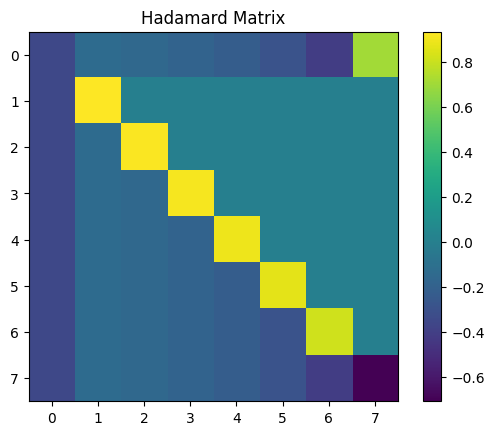

In [97]:
from scipy.linalg import expm
import numpy as np
import matplotlib.pyplot as plt

def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    # if not (0 <= f <= 1):
    #     raise ValueError("Fraction f must be between 0 and 1.")
    theta = np.pi*np.array(f)#2.0 * np.arcsin(np.sqrt(f))
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):

    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq


def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags


# dim = 4
# init_state = np.array([1,0,0,0])
# couplings = [(0, 3), (0, 2), (0, 1), (0, 2), (0, 3)]
# fractions = [0.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2.0 * np.arcsin(np.sqrt(3/4))/np.pi, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 1.5]
# fixed_phase_flags = [1.5, 0.5, 0.5, 0.5, 1.5]
# rabi_freqs = [1,1,1,1,1,1,1]

dim = 8
init_state = np.array([1,0,0,0,0,0,0,0])
couplings =  [(0, 6), (0, 1), (0, 3), (0, 5), (0, 4), (0, 2), (0, 4), (0, 5), (0, 7), (0, 3), (0, 1), (0, 2), (0, 4), (0, 7), (0, 1), (0, 5), (0, 3), (0, 6), (0, 7), (0, 1), (0, 6)]
fractions =  [1.5, 1, 1., 1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2/3, 1 + 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 1, 1, 0.5, 0.5, 0.5, 1.0, 1.5, 1.0, 1.5, 1, 1.5, 1.5, 1, 1.5]
fixed_phase_flags =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5]
rabi_freqs = [1]*len(couplings)

couplings = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]
fractions = [2*np.arcsin(np.sqrt(1/8))/np.pi, 2*np.arcsin(np.sqrt(1/7))/np.pi, 2*np.arcsin(np.sqrt(1/6))/np.pi, 2*np.arcsin(np.sqrt(1/5))/np.pi, 2*np.arcsin(np.sqrt(1/4))/np.pi, 2*np.arcsin(np.sqrt(1/3))/np.pi, 2*np.arcsin(np.sqrt(1/2))/np.pi+1]
fixed_phase_flags = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
print(couplings, fixed_phase_flags)
U1 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print(np.round(U1,3))
print('________________________')
print(np.round(U1@init_state,3))
plt.figure()
plt.imshow(np.real(U1), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Hadamard Matrix")

plt.show()


Calculated Unitary for d=8:
[[-0.193+0.j -0.354+0.j -0.193+0.j -0.193+0.j -0.193+0.j -0.193+0.j
  -0.193+0.j -0.807+0.j]
 [-0.354-0.j  0.354+0.j -0.354+0.j -0.354+0.j -0.354+0.j -0.354+0.j
  -0.354-0.j  0.354-0.j]
 [-0.193-0.j -0.354+0.j  0.807-0.j -0.193+0.j -0.193+0.j -0.193+0.j
  -0.193-0.j  0.193-0.j]
 [-0.193-0.j -0.354+0.j -0.193-0.j  0.807-0.j -0.193-0.j -0.193-0.j
  -0.193-0.j  0.193-0.j]
 [-0.193-0.j -0.354+0.j -0.193-0.j -0.193+0.j  0.807-0.j -0.193-0.j
  -0.193-0.j  0.193-0.j]
 [-0.193-0.j -0.354-0.j -0.193-0.j -0.193+0.j -0.193-0.j  0.807-0.j
  -0.193-0.j  0.193-0.j]
 [-0.193-0.j -0.354+0.j -0.193+0.j -0.193+0.j -0.193+0.j -0.193-0.j
   0.807+0.j  0.193-0.j]
 [-0.807-0.j  0.354+0.j  0.193+0.j  0.193+0.j  0.193+0.j  0.193+0.j
   0.193+0.j -0.193+0.j]]
________________________
Checking action on basis states (showing magnitudes):
Target magnitude for each element: 0.354
|U|0>| magnitudes: [0.193 0.354 0.193 0.193 0.193 0.193 0.193 0.807]
State |0> DOES NOT transform correctly

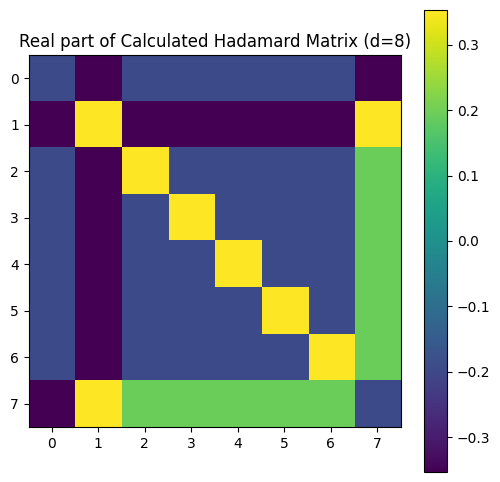

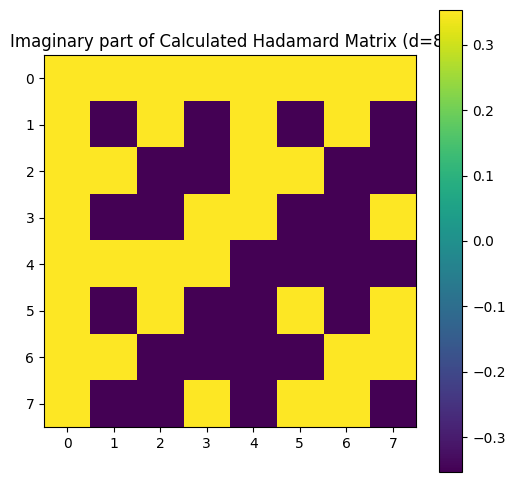

In [462]:
from scipy.linalg import expm
import numpy as np
import matplotlib.pyplot as plt

# --- Functions (copied from your example) ---
def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):
    # Original formula: theta = 2.0 * np.arcsin(np.sqrt(f)) assumes f is probability
    # Your usage: theta = np.pi * f assumes f is theta/pi
    # We will stick to your usage where f = theta/pi
    theta = np.pi * np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        # Ensure coupling is (0, k) with k > 0 if needed (already done in our sequence)
        # phi_fixed is the flag * pi
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega) # t_pulse is actually theta/Omega
        # The evolution is U = expm(-i H t)
        # H = (Omega/2) * op = (Omega/2) * [0 exp(i*phi); exp(-i*phi) 0]
        # theta = Omega * t_pulse
        # U_pulse = expm(-i * (Omega/2) * op * (theta/Omega)) = expm(-i * (theta/2) * op)
        # This matches the standard Givens rotation definition when op is defined as above.
        U_pulse = expm(-1j * H_coupling * t_pulse) # t_pulse = theta/Omega
        U_seq = U_pulse @ U_seq
    return U_seq

# --- Parameters for n=3 (d=8) ---
dim = 8
num_rotations = 13

# 1. Coupling Sequence (0,k) where k goes from d-1 down to 1 and back up to d-1
couplings = [(0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), \
             (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)]

# 2. Fixed Phase Flags (1.5 for outermost k=7, 0.5 for others)
fixed_phase_flags = [1.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, \
                     0.5, 0.5, 0.5, 0.5, 0.5, 1.5]

# 3. Fractions f = theta/pi (derived from probabilities p)
asin = np.arcsin
pi = np.pi
sqrt = np.sqrt
fractions = [
    0.5,                      # k=7, p=1/2 (first)
    2*asin(sqrt(1/3))/pi,     # k=6, p=1/3
    1/3,                      # k=5, p=1/4
    2*asin(sqrt(1/5))/pi,     # k=4, p=1/5
    2*asin(sqrt(1/6))/pi,     # k=3, p=1/6
    2*asin(sqrt(1/7))/pi,     # k=2, p=1/7
    2*asin(sqrt(7/8))/pi,     # k=1, p=7/8
    2*asin(sqrt(1/7))/pi,     # k=2, p=1/7
    2*asin(sqrt(1/6))/pi,     # k=3, p=1/6
    2*asin(sqrt(1/5))/pi,     # k=4, p=1/5
    1/3,                      # k=5, p=1/4
    2*asin(sqrt(1/3))/pi,     # k=6, p=1/3
    1.5                       # k=7, p=1/2 (last)
]

# Assuming unit Rabi frequencies for simplicity
rabi_freqs = np.ones(num_rotations)

# No need to call fix_couplings_and_phases as they are already in (0,k) format
# couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)

# Calculate the unitary
U_hadamard_d8 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)

# --- Verification (Optional) ---
print(f"Calculated Unitary for d={dim}:")
# Use lower precision for easier visual inspection if needed
# np.set_printoptions(precision=3, suppress=True)
print(np.round(U_hadamard_d8, 3))
print('________________________')

# Check if applying U to basis states yields equal superposition (check magnitudes)
print("Checking action on basis states (showing magnitudes):")
target_mag = 1/np.sqrt(dim)
print(f"Target magnitude for each element: {target_mag:.3f}")
for k in range(dim):
    init_state_k = np.zeros(dim)
    init_state_k[k] = 1.0
    final_state = U_hadamard_d8 @ init_state_k
    magnitudes = np.abs(final_state)
    print(f"|U|{k}>| magnitudes: {np.round(magnitudes, 3)}")
    # Check if all magnitudes are close to 1/sqrt(d)
    if np.allclose(magnitudes, target_mag):
        print(f"State |{k}> transforms correctly (equal superposition magnitudes).")
    else:
        print(f"State |{k}> DOES NOT transform correctly.")

# Compare with standard Walsh-Hadamard matrix (up to phases and permutations)
from scipy.linalg import hadamard
H_walsh = hadamard(dim) / np.sqrt(dim)
print("\nStandard Walsh-Hadamard (for comparison):")
print(np.round(H_walsh, 3))


# Visualize the real part of the calculated matrix
plt.figure(figsize=(6,6))
plt.imshow(np.real(U_hadamard_d8), cmap='viridis', interpolation='nearest', vmin=-1/sqrt(dim), vmax=1/sqrt(dim))
plt.colorbar()
plt.title(f"Real part of Calculated Hadamard Matrix (d={dim})")
plt.xticks(np.arange(dim))
plt.yticks(np.arange(dim))
# plt.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(np.real(H_walsh), cmap='viridis', interpolation='nearest', vmin=-1/sqrt(dim), vmax=1/sqrt(dim))
plt.colorbar()
plt.title(f"Imaginary part of Calculated Hadamard Matrix (d={dim})")
plt.xticks(np.arange(dim))
plt.yticks(np.arange(dim))
# plt.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
plt.show()

--- Input Parameters After Fixing ---
Fixed Couplings: [(0, 3), (0, 1), (0, 2), (0, 1), (0, 3)]
Fixed Phase Flags: [1.5, 0.5, 1.5, 0.5, 0.5]
Fractions: [0.5        0.39182655 1.33333333 1.60817345 0.5       ]
Dimension: 4
-------------------------------------

--- Matrix Exponential Method ---
Unitary (Rounded):
 [[ 0.5+0.j  0.5-0.j  0.5-0.j  0.5-0.j]
 [ 0.5+0.j -0.5-0.j  0.5-0.j -0.5+0.j]
 [ 0.5+0.j  0.5+0.j -0.5-0.j -0.5-0.j]
 [ 0.5+0.j -0.5-0.j -0.5+0.j  0.5+0.j]]

Final State (Rounded): [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
---------------------------------

--- Givens Rotation Method ---
Unitary (Rounded):
 [[ 0.5+0.j  0.5-0.j  0.5-0.j  0.5-0.j]
 [ 0.5+0.j -0.5+0.j  0.5-0.j -0.5+0.j]
 [ 0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]
 [ 0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]]

Final State (Rounded): [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
------------------------------

--- Comparison ---
Unitary matrices are close: True
Final states are close: True
------------------



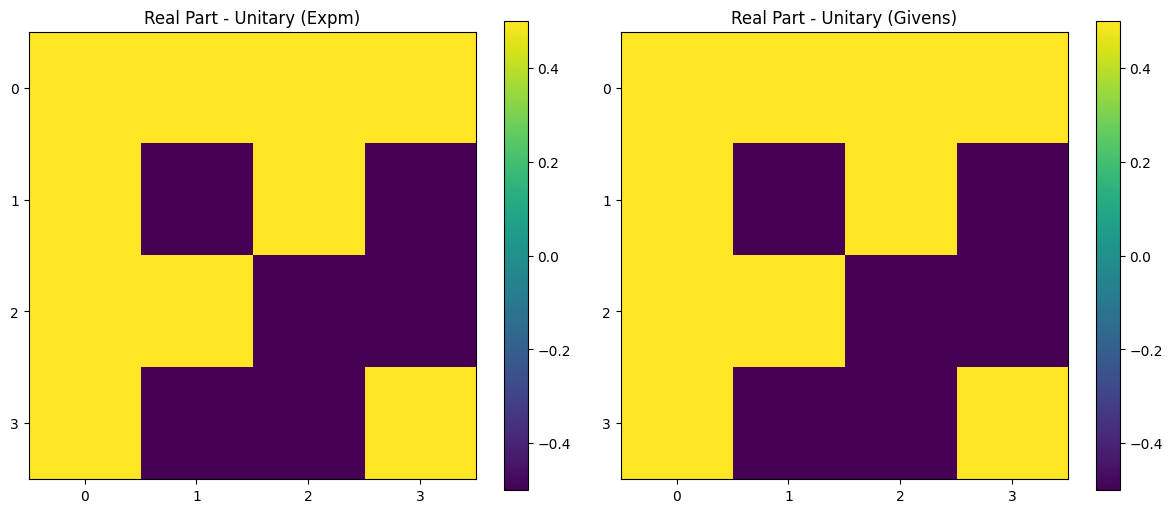

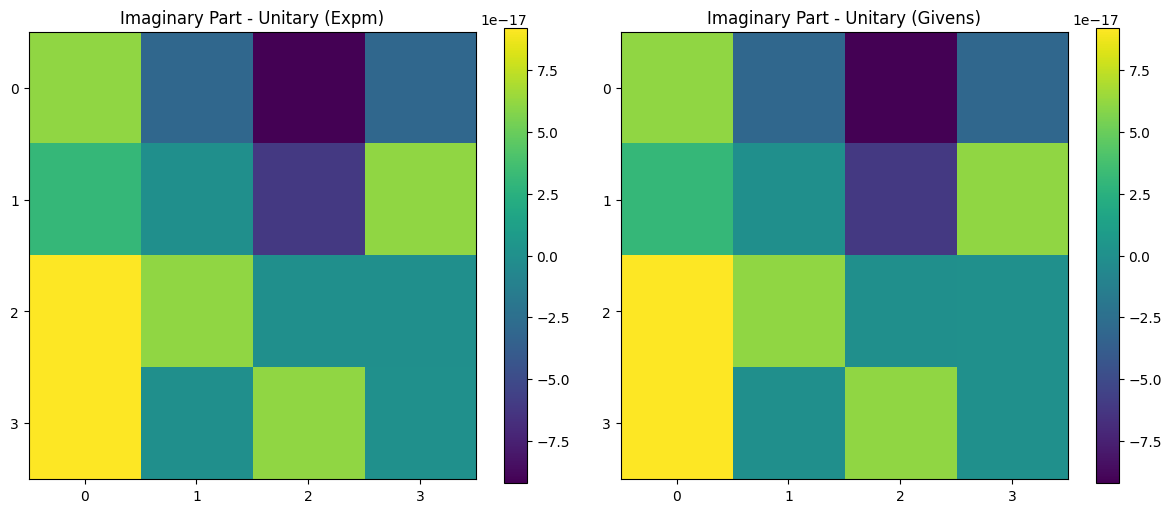

In [156]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

def coupling_operator_with_phase(i, j, dim, phi):
    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    theta = np.pi * np.array(f)
    return theta / Omega if Omega != 0 else 0.0

def unitary_expm(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq # Apply pulse from the left
    return U_seq


def givens_rotation_matrix(i, j, dim, angle, phase):

    if i == j:
        # No rotation if indices are the same
        return np.eye(dim, dtype=complex)

    G = np.eye(dim, dtype=complex)
    c = np.cos(angle)
    s = np.sin(angle)
    exp_iphi = np.exp(1j * phase)
    exp_m_iphi = np.exp(-1j * phase) # Equivalent to np.conjugate(exp_iphi)

    G[i, i] = c
    G[i, j] = -1j * exp_iphi * s
    G[j, i] = -1j * exp_m_iphi * s
    G[j, j] = c

    return G

def unitary_givens(couplings, fractions, fixed_phase_flags, dim):

    U_seq = np.eye(dim, dtype=complex)
    for (levels, frac, fix_pflag) in zip(couplings, fractions, fixed_phase_flags):
        i, j = levels
        # Calculate the phase phi for the Givens rotation
        total_phase = fix_pflag * np.pi
        # Calculate the rotation angle theta for the Givens rotation
        # angle = (pi * fraction) / 2
        angle = (np.pi * frac) / 2.0

        U_pulse = givens_rotation_matrix(i, j, dim, angle, total_phase)

        U_seq = U_pulse @ U_seq 

    return U_seq

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        # Ensure consistent ordering (e.g., i < j or 0 is always first if present)
        # The original logic swaps (i, 0) to (0, i) and adjusts phase.
        # Let's replicate that specific logic.
        if i != 0 and j == 0:
             cpl_fixed = (0, i)
             phase_flag_fixed = phase_flag + 1.0 # Adds pi to the phase
        # Optional: Add general sorting if needed for consistency, e.g.,
        # elif i > j:
        #     cpl_fixed = (j, i)
        #     phase_flag_fixed = -phase_flag # Conjugate phase if swapping general indices
        #     # Note: The original code *only* handles the (i, 0) case specifically.
        #     # We will stick to the original logic.
        else:
             cpl_fixed = cpl
             phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags


# --- Example Usage & Comparison ---

# Use the final example from your script
init_state = np.array([1,0,0,0])
dim = 4
couplings = [(0, 3), (0, 1), (0, 2), (0, 1), (0, 3)]
# Ensure fractions are floats for calculations
fractions = np.array([0.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 4/3, 2.0 * np.arcsin(np.sqrt(2/3))/np.pi + 1, 0.5])
fixed_phase_flags = np.array([1.5, 0.5, 1.5, 0.5, 0.5])
rabi_freqs = np.array([1,1,1,1,1]) # Needed only for expm version

# Apply the fixing step FIRST, as in the original script
couplings_fixed, fixed_phase_flags_fixed = fix_couplings_and_phases(couplings, fixed_phase_flags)

print("--- Input Parameters After Fixing ---")
print("Fixed Couplings:", couplings_fixed)
print("Fixed Phase Flags:", fixed_phase_flags_fixed)
print("Fractions:", fractions)
print("Dimension:", dim)
print("-------------------------------------\n")

# Calculate Unitary using Matrix Exponential
print("--- Matrix Exponential Method ---")
U_expm = unitary_expm(couplings_fixed, rabi_freqs, fractions, fixed_phase_flags_fixed, dim)
print("Unitary (Rounded):\n", np.round(U_expm, 5))
final_state_expm = U_expm @ init_state
print("\nFinal State (Rounded):", np.round(final_state_expm, 5))
print("---------------------------------\n")


# Calculate Unitary using Givens Rotations
print("--- Givens Rotation Method ---")
# Note: rabi_freqs are NOT needed for the Givens implementation
U_givens = unitary_givens(couplings_fixed, fractions, fixed_phase_flags_fixed, dim)
print("Unitary (Rounded):\n", np.round(U_givens, 5))
final_state_givens = U_givens @ init_state
print("\nFinal State (Rounded):", np.round(final_state_givens, 5))
print("------------------------------\n")

# --- Verification ---
print("--- Comparison ---")
are_matrices_close = np.allclose(U_expm, U_givens)
print(f"Unitary matrices are close: {are_matrices_close}")

are_states_close = np.allclose(final_state_expm, final_state_givens)
print(f"Final states are close: {are_states_close}")
print("------------------\n")

# --- Visualization (Optional) ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.real(U_expm), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Real Part - Unitary (Expm)")
plt.xticks(np.arange(dim))
plt.yticks(np.arange(dim))

plt.subplot(1, 2, 2)
plt.imshow(np.real(U_givens), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Real Part - Unitary (Givens)")
plt.xticks(np.arange(dim))
plt.yticks(np.arange(dim))

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.imag(U_expm), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Imaginary Part - Unitary (Expm)")
plt.xticks(np.arange(dim))
plt.yticks(np.arange(dim))

plt.subplot(1, 2, 2)
plt.imshow(np.imag(U_givens), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Imaginary Part - Unitary (Givens)")
plt.xticks(np.arange(dim))
plt.yticks(np.arange(dim))

plt.tight_layout()
plt.show()

In [95]:
2.0 * np.arcsin(np.sqrt(2/3))/np.pi + 1

1.6081734479693928

In [311]:
import numpy as np

def sequence_from_populations(init_pop, final_pop, tol=1e-8):
    """
    Find a sequence of two-level pulses (couplings, fractions, phases)
    that takes you from init_pop to final_pop, using only populations.

    Returns
    -------
    couplings : list of (i,j) tuples
    fractions : list of floats f  (pulse area = π f)
    phase_flags : list of floats φ/π  (we use 0.5 to cancel -i)
    """
    init_pop  = np.asarray(init_pop, float)
    final_pop = np.asarray(final_pop, float)
    if abs(init_pop.sum() - 1) > tol or abs(final_pop.sum() - 1) > tol:
        raise ValueError("Both init_pop and final_pop must sum to 1.")
    N = len(init_pop)
    current = init_pop.copy()

    # start with the level that has the most population
    reservoir = int(np.argmax(current))

    couplings = []
    fractions = []
    phase_flags = []

    for j in range(N):
        if j == reservoir:
            continue
        # if this level already has the right pop, skip it
        if abs(current[j] - final_pop[j]) < tol:
            continue

        # ensure there's “room” to mix between reservoir and j
        denom = current[reservoir] - current[j]
        if denom <= tol:
            # pick a different reservoir if they’re equal
            candidates = [k for k in range(N)
                          if k != j and current[k] - current[j] > tol]
            if not candidates:
                raise ValueError(f"Cannot adjust level {j}, no valid reservoir left.")
            reservoir = candidates[0]
            denom = current[reservoir] - current[j]

        # how much extra pop we need in j?
        num = final_pop[j] - current[j]
        sin2 = num / denom
        # numerical safety
        sin2 = max(0.0, min(1.0, sin2))

        # rotation angle θ satisfies: sin²(θ/2) = sin2
        θ = 2 * np.arcsin(np.sqrt(sin2))

        f = θ / np.pi       # fraction of a π-pulse
        φ_flag = 0.5        # means φ = π/2, cancels the “-i” in U

        # record this pulse
        couplings.append((reservoir, j))
        fractions.append(f)
        phase_flags.append(φ_flag)

        # update the two populations
        p_r = current[reservoir]
        p_j = current[j]
        current[j]              = final_pop[j]
        current[reservoir] = p_r + p_j - final_pop[j]

    return couplings, fractions, phase_flags


# --- example on your numbers ---
init_pop  = [0.0178571, 0.125,     0.8571429, 0]
final_pop = [0.75,      0.125,     0.125,      0]

couplings, fractions, phases = sequence_from_populations(init_pop, final_pop)
print("couplings:     ", couplings)
print("fractions f:   ", np.round(fractions,10))
print("phase_flags:   ", phases)


couplings:      [(2, 0)]
fractions f:    [0.76739826]
phase_flags:    [0.5]


In [469]:
from scipy.linalg import expm
import numpy as np

def state_evolution(couplings, rabi_freqs, fractions, fixed_phase_flags, init_state, dim):

    states = [init_state]
    current_state = init_state.copy()
    pops = [np.abs(states)]
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels

        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed

        H_op = coupling_operator_with_phase(i, j, dim, total_phase)

        H_coupling = 0.5 * Omega * H_op

        t_pulse = pulse_duration_for_fraction(frac, Omega)

        U_pulse = expm(-1j * H_coupling * t_pulse)

        current_state = U_pulse @ current_state

        states.append(current_state)
        pops.append(np.abs(current_state)**2)
    return states,pops

# Define your parameters (example)
dim = 4
init_state = np.array([1,0,0,0])
couplings = [(0, 3), (0, 2), (0, 1), (0, 2), (0, 3)]
fractions = [0.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2.0 * np.arcsin(np.sqrt(3/4))/np.pi, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 1.5]
fixed_phase_flags = [1.5, 0.5, 0.5, 0.5, 1.5]

couplings  =  [(0, 1), (0, 2), (0, 3), (0, 1), (0, 2), (0, 3), (0, 1), (0, 2), (0, 3), (0, 2), (0, 3), (0, 3)]
fractions =  [0.5, 0.3918265520306073, 0.33333333333333326, 1.0, 1.6666666666666667, 0.3918265520306073, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0]
fixed_phase_flags =  [0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 0.5, 0.5, 0.5]

rabi_freqs = [1]*len(couplings)

# Evolve the state and get intermediate states
states_sequence,pop_seq = state_evolution(couplings, rabi_freqs, fractions, fixed_phase_flags, init_state, dim)

# Print out the state after each pulse
for idx, state in enumerate(states_sequence[1:]):
    print(f"State after pulse {idx}: {couplings[idx]}")
    print(np.round(state,3),'\n',np.round(pop_seq[idx+1],3))
    print(np.arctan(np.imag(state[0])/np.real(state[0])))
    print("---------")


State after pulse 0: (0, 1)
[ 0.707-0.j -0.707-0.j  0.   +0.j  0.   +0.j] 
 [0.5 0.5 0.  0. ]
-4.357881996052623e-33
---------
State after pulse 1: (0, 2)
[ 0.577-0.j -0.707-0.j -0.408-0.j  0.   +0.j] 
 [0.333 0.5   0.167 0.   ]
-2.4708637384144185e-33
---------
State after pulse 2: (0, 3)
[ 0.5  -0.j -0.707-0.j -0.408-0.j -0.289-0.j] 
 [0.25  0.5   0.167 0.083]
-2.470863738414419e-33
---------
State after pulse 3: (0, 1)
[-0.707-0.j -0.5  -0.j -0.408-0.j -0.289-0.j] 
 [0.5   0.25  0.167 0.083]
1.7431527984210495e-32
---------
State after pulse 4: (0, 2)
[ 0.408+0.j -0.5  -0.j  0.707+0.j -0.289-0.j] 
 [0.167 0.25  0.5   0.083]
7.170669379025175e-32
---------
State after pulse 5: (0, 3)
[ 0.5  -0.j -0.5  -0.j  0.707+0.j  0.   +0.j] 
 [0.25 0.25 0.5  0.  ]
-4.082155997157837e-17
---------
State after pulse 6: (0, 1)
[-0.5  +0.j -0.5  -0.j  0.707+0.j  0.   +0.j] 
 [0.25 0.25 0.5  0.  ]
-0.0
---------
State after pulse 7: (0, 2)
[ 0.707+0.j -0.5  -0.j  0.5  +0.j  0.   +0.j] 
 [0.5  0.25 0.

In [445]:
from scipy.linalg import expm
import numpy as np

def state_evolution(couplings, rabi_freqs, fractions, fixed_phase_flags, init_state, dim):

    states = [init_state]
    current_state = init_state.copy()
    pops = [np.abs(states)]
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels

        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed

        H_op = coupling_operator_with_phase(i, j, dim, total_phase)

        H_coupling = 0.5 * Omega * H_op

        t_pulse = pulse_duration_for_fraction(frac, Omega)

        U_pulse = expm(-1j * H_coupling * t_pulse)

        current_state = U_pulse @ current_state

        states.append(current_state)
        pops.append(np.abs(current_state)**2)
    return states,pops

# Define your parameters (example)
dim = 8
init_state = np.array([0,0,0,1,0,0,0,0])
couplings = [(0,7),(0,6),(0,5),(0,4),(0,3),(0,2),(0,1)] \
         +  [(0,7),(0,6),(0,5),(0,4),(0,3),(0,2)][::-1]
fractions = [2.0 * np.arcsin(np.sqrt(1/2))/np.pi, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2.0 * np.arcsin(np.sqrt(1/4))/np.pi,2.0 * np.arcsin(np.sqrt(1/5))/np.pi,2.0 * np.arcsin(np.sqrt(1/6))/np.pi, 2.0 * np.arcsin(np.sqrt(1/7))/np.pi,2.0 * np.arcsin(np.sqrt(7/8))/np.pi,\
             2.0 * np.arcsin(np.sqrt(0.743611875))/np.pi]

fixed_phase_flags = [0.5,0.5,0.5,0.5,0.5,0.5,1.5,\
                     1.5]
rabi_freqs = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

states_sequence,pop_seq = state_evolution(couplings, rabi_freqs, fractions, fixed_phase_flags, init_state, dim)

for idx, state in enumerate(states_sequence[1:]):
    print(f"State after pulse {idx}: {couplings[idx]}")
    print(np.round(state,7))
    print(np.round(pop_seq[idx+1],15))
    # print(np.arctan(np.imag(state[0])/np.real(state[0])))
    print("---------")


State after pulse 0: (0, 7)
[0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0. 0. 0. 1. 0. 0. 0. 0.]
---------
State after pulse 1: (0, 6)
[0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0. 0. 0. 1. 0. 0. 0. 0.]
---------
State after pulse 2: (0, 5)
[0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0. 0. 0. 1. 0. 0. 0. 0.]
---------
State after pulse 3: (0, 4)
[0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0. 0. 0. 1. 0. 0. 0. 0.]
---------
State after pulse 4: (0, 3)
[0.4082483-0.j 0.       +0.j 0.       +0.j 0.9128709+0.j 0.       +0.j
 0.       +0.j 0.       +0.j 0.       +0.j]
[0.16666667 0.         0.         0.83333333 0.         0.
 0.         0.        ]
---------
State after pulse 5: (0, 2)
[ 0.3779645-0.j  0.       +0.j -0.1543033+0.j  0.9128709+0.j
  0.       +0.j  0.       +0.j  0.       +0.j  0.       +0.j]
[0.14285714 0.         0.02380952 0.83333333 0.         0.
 0.         0.        ]
---------
State after pulse 6: (0, 1)
[ 0.

In [141]:
from fractions import Fraction
Fraction(0.39182654).limit_denominator()

Fraction(368813, 941266)

In [81]:
import numpy as np
from scipy.linalg import expm


def is_zero_matrix(mat, tol=1e-12):
    return np.allclose(mat, 0.0, atol=tol)

def check_commutations(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):
    """
    For each set of 3 couplings, build a single unitary 'operator'.
    Then check commutation between consecutive sets (operators).
    Returns a list: +1 if commute, -1 if anticommute, 0 otherwise.
    """
    operators = []
    for cpl_triplet, rb_triplet, fr_triplet, ph_triplet in zip(
        couplings, rabi_freqs, fractions, fixed_phase_flags
    ):
        operators.append(unitary(cpl_triplet, rb_triplet, fr_triplet, ph_triplet, dim))

    results = []
    for k in range(len(operators) - 1):
        A = operators[k]
        B = operators[k + 1]
        comm = A @ B - B @ A
        anticomm = A @ B + B @ A
        if is_zero_matrix(comm):
            results.append(1)    # Commute
        elif is_zero_matrix(anticomm):
            results.append(-1)   # Anticommute
        else:
            results.append(0)    # Neither
    return results

def is_similar_coupling(a, b):

    return (a == b) or (a == (b[1], b[0]))

def reorder_couplings(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):

    comm_list = check_commutations(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)

    set_info = []
    for idx, (cpl_triplet, rb_triplet, fr_triplet, ph_triplet) in enumerate(
        zip(couplings, rabi_freqs, fractions, fixed_phase_flags)
    ):
        start_c = cpl_triplet[0]
        end_c   = cpl_triplet[-1]
        set_info.append({
            "idx"      : idx,
            "couplings": cpl_triplet,
            "rabis"    : rb_triplet,
            "fractions": fr_triplet,
            "phases"   : ph_triplet,
            "start"    : start_c,
            "end"      : end_c
        })

    n = len(set_info)
    improved = True
    while improved:
        improved = False
        comm_list = check_commutations(
            [si["couplings"] for si in set_info],
            [si["rabis"]    for si in set_info],
            [si["fractions"]for si in set_info],
            [si["phases"]   for si in set_info],
            dim
        )
        for i in range(n - 1):
            current_set = set_info[i]
            next_set    = set_info[i + 1]
            # If they commute and end/start are 'similar' => good, no change needed
            if (
                comm_list[i] == 1 and 
                is_similar_coupling(current_set["end"], next_set["start"])
            ):
                continue
            # Else see if there is a better candidate further in the list
            for j in range(i + 2, n):
                cand_set = set_info[j]
                # If candidate commutes with current_set
                # and the boundary couplings match up
                # let's do a swap in the ordering
                if (
                    # We'll do a local check: build the 2 unitaries & see if they commute:
                    # Or just rely on boundary couplings + a subsequent comm_list check
                    is_similar_coupling(current_set["end"], cand_set["start"])
                ):
                    # We'll check if they commute in principle:
                    # Temporarily swap candidate into position i+1
                    set_info[i + 1], set_info[j] = set_info[j], set_info[i + 1]
                    # Recompute local comm to see if improved
                    # (For simplicity, we won't do it right now, we rely on the final pass.)
                    improved = True
                    break
            if improved:
                # Break out of the for-loop to start the while-pass again
                break

    # 3) Rebuild the final lists from set_info
    new_couplings        = [si["couplings"] for si in set_info]
    new_rabi_freqs       = [si["rabis"]     for si in set_info]
    new_fractions        = [si["fractions"] for si in set_info]
    new_fixed_phase_flags= [si["phases"]    for si in set_info]

    return new_couplings, new_rabi_freqs, new_fractions, new_fixed_phase_flags

dim = 9
couplings = [[(2,0),(0,1),(2,0)] , [(4,0),(3,0)]  , [(0,1),(3,0)] , [(0,2),(4,0)]] 
fractions = [[1,1/2,1] , [1,1/2]  , [1/2,1] , [1/2,1]]
rabi_freqs = [[1,1,1],[1,1],[1,1,1],[1,1]]       
fixed_phase_flags = [[0.5,0.5,0.5] , [0.5,0.5]  , [0.5,0.5] , [0.5,0.5]]

couplings = [[(2,0),(0,1),(2,0)] , [(4,0),(0,3)] , [(0,2),(4,0)], [(3,0),(0,1),(3,0)]  ] 
fractions = [[1,1/2,1] , [1,1/2,1] , [1,1/2,1] , [1,1/2,1]]
rabi_freqs = [[1,1,1],[1,1,1],[1,1,1],[1,1,1]]       
fixed_phase_flags = [[0.5,0.5,0.5] , [0.5,0.5,0.5] , [0.5,0.5,0.5] , [0.5,0.5,0.5]]



original_comm_list = check_commutations(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print("Original commutation checks:", original_comm_list)

# Reorder
(re_couplings, re_rabi_freqs, re_fracs, re_phases) = reorder_couplings(
    couplings,
    rabi_freqs,
    fractions,
    fixed_phase_flags,
    dim
)
new_comm_list = check_commutations(re_couplings, re_rabi_freqs, re_fracs, re_phases, dim)

print("\nNew ordering of couplings (start/end shown):")
for idx, triple in enumerate(re_couplings):
    print(f"Set {idx}: {triple} (start: {triple[0]}, end: {triple[-1]})")
print("\nNew commutation checks:", new_comm_list)


Original commutation checks: [0, 0, 0]

New ordering of couplings (start/end shown):
Set 0: [(2, 0), (0, 1), (2, 0)] (start: (2, 0), end: (2, 0))
Set 1: [(0, 2), (4, 0)] (start: (0, 2), end: (4, 0))
Set 2: [(4, 0), (0, 3)] (start: (4, 0), end: (0, 3))
Set 3: [(3, 0), (0, 1), (3, 0)] (start: (3, 0), end: (3, 0))

New commutation checks: [0, 0, 0]


In [27]:
def build_index_map(strings):
    special_values = {"0", "-2"}
    # Separate special strings (like '0' or '-2') from the rest
    special = [s for s in strings if s in special_values]
    normal = [s for s in strings if s not in special_values]

    # Assign index 0 to all special strings
    index_map = {}
    for s in special:
        index_map[0] = s

    # Assign subsequent indices to normal strings
    current_index = 1
    for s in normal:
        index_map[current_index] = s
        current_index += 1

    return index_map

strings = ['[2, -1]', '[3, -2]', '[4, -4]', '[3, -3]', '-2']
mapping = build_index_map(strings)
print(mapping)


{0: '-2', 1: '[2, -1]', 2: '[3, -2]', 3: '[4, -4]', 4: '[3, -3]'}


In [29]:
def parse_string_to_int_list(s):
    s = s.strip()
    if s.startswith('[') and s.endswith(']'):
        inside = s[1:-1].strip()
        parts = inside.split(',')
        return [int(x) for x in parts]
    else:
        return [int(s)]

def build_transitions_list(index_to_str_map, couplings):
    transitions_list = []
    for (start_idx, end_idx) in couplings:
        left_list  = parse_string_to_int_list(index_to_str_map[start_idx])
        right_list = parse_string_to_int_list(index_to_str_map[end_idx])
        transitions_list.append(left_list + right_list)
    return transitions_list
print(couplings)
print(build_transitions_list(mapping,couplings))

[(2, 0), (0, 1), (2, 0), (4, 0), (3, 0), (0, 1), (3, 0), (0, 2), (4, 0)]
[[3, -2, -2], [-2, 2, -1], [3, -2, -2], [3, -3, -2], [4, -4, -2], [-2, 2, -1], [4, -4, -2], [-2, 3, -2], [3, -3, -2]]


[[ 1.   +0.j  0.   +0.j -0.   +0.j  0.   +0.j  0.   -0.j  0.   +0.j
  -0.   +0.j  0.   +0.j  0.   -0.j]
 [ 0.   +0.j  0.354-0.j  0.354+0.j  0.354+0.j  0.354+0.j  0.354+0.j
   0.354+0.j  0.354+0.j  0.354+0.j]
 [ 0.   +0.j  0.354-0.j -0.354+0.j  0.354+0.j -0.354-0.j  0.354+0.j
  -0.354-0.j  0.354+0.j -0.354-0.j]
 [ 0.   +0.j  0.354-0.j  0.354-0.j -0.354-0.j -0.354+0.j  0.354+0.j
   0.354+0.j -0.354-0.j -0.354-0.j]
 [ 0.   +0.j  0.354-0.j -0.354+0.j -0.354+0.j  0.354-0.j  0.354+0.j
  -0.354-0.j -0.354-0.j  0.354+0.j]
 [ 0.   -0.j  0.354-0.j  0.354-0.j  0.354-0.j  0.354-0.j -0.354-0.j
  -0.354-0.j -0.354-0.j -0.354-0.j]
 [ 0.   -0.j  0.354-0.j -0.354+0.j  0.354-0.j -0.354+0.j -0.354+0.j
   0.354+0.j -0.354-0.j  0.354+0.j]
 [-0.   +0.j  0.354-0.j  0.354-0.j -0.354+0.j -0.354+0.j -0.354+0.j
  -0.354+0.j  0.354+0.j  0.354+0.j]
 [-0.   -0.j  0.354-0.j -0.354+0.j -0.354+0.j  0.354-0.j -0.354+0.j
   0.354+0.j  0.354+0.j -0.354+0.j]]
________________________ 27
[0. +0.j 0.4-0.j 0.4-0.j 0.4-0.j 0.

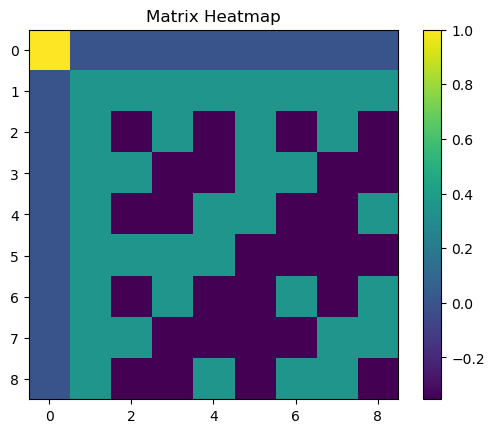

In [158]:
dim = 9

init_state = np.array([0,1,0,0,0,0,0,0,0])

couplings = [(2,0),(0,1),(2,0)] + [(4,0),(0,3),(4,0)] + [(3,0),(0,1),(3,0)]  + [(4,0),(0,2),(4,0)] + [(6,0),(0,5),(6,0)] + [(8,0),(0,7),(8,0)] + [(7,0),(0,5),(7,0)] + [(8,0),(0,6),(8,0)] \
 + [(5,0),(0,1),(5,0)] + [(6,0),(0,2),(6,0)] + [(7,0),(0,3),(7,0)] + [(8,0),(0,4),(8,0)]
fractions = [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1] \
 + [1,1/2,1] + [1,1/2,1] + [1,1/2,1] + [1,1/2,1]
rabi_freqs = [1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]+[1,1,1]       
fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] \
 + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5]

dim = 9
init_state = np.array([0,1,0,0,0,0,0,0,0])
couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)]\
          + [(6,0),(0,5),(6,0)] + [(8,0),(7,0)]  + [(0,5),(7,0)] + [(6,0)]\
          + [(0,2),(6,0)] + [(5,0),(0,1),(5,0)] + [(7,0),(0,3),(7,0)] + [(0,4),(8,0)]
fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]\
          + [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2]\
          + [1/2,1] + [1,1/2,1] + [1,1/2,1] + [1/2,1]
rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]\
           + [1,1,1]+[1,1]+[1,1]+[1,1]\
           +[1,1]+[1,1,1]+[1,1,1]+[1,1,1]
fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]\
                   +[0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5]\
                   + [0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5]

# dim = 5
# init_state = np.array([0,0,1,0,0])
# couplings = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)]
# fractions = [1, 1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2/3, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 0.5, 1]
# fixed_phase_flags = [0, 1, 0, 1, 0, 1, 1]
# rabi_freqs = [1,1,1,1,1,1,1]

# dim = 5
# init_state = np.array([0,0,1,0,0])
# couplings = [(0, 1), (0, 4), (0, 2), (0, 3), (0, 2), (0, 4), (0, 1)]
# fractions = [0.9999999987044689, 1.4999999961377783, 1.6081734388924585, 1.3333333298840944, 0.39182654160586444, 1.499999995390457, 0.9999999947010305]
# fixed_phase_flags = [1, 1, 1, 0, 1, 0, 0]
# rabi_freqs = [1,1,1,1,1,1,1]

# dim = 9
# init_state = np.array([0,1,0,0,0,0,0,0,0])
# couplings = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 6), (0, 7), (0, 5), (0, 8), (0, 5), (0, 7), (0, 6), (0, 4), (0, 1), (0, 3), (0, 2)]
# fractions = [1.0, 1.5000000000000001, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2.0 * np.arcsin(np.sqrt(1/4))/np.pi, 2.0 * np.arcsin(np.sqrt(1/5))/np.pi, 2.0 * np.arcsin(np.sqrt(1/6))/np.pi, 2.0 * np.arcsin(np.sqrt(1/7))/np.pi, 2.0 * np.arcsin(np.sqrt(1/8))/np.pi, 0.24675171442884983, 0.26772047280123, 0.2951672353008665, 0.33333333333333337, 0.3918265520306073, 0.5000000000000001, 1.0]
# fixed_phase_flags = [0,1,0,1,0,0,0,0,0,0,0,0,0,0,0]
# rabi_freqs = [1,1,1,1,1,1,1]#,1,1,1,1,1,1,1,1]
# print(couplings)

U1 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print(np.round(U1,3))
print('________________________',len(couplings))
print(np.round(U1@init_state,1))
plt.figure()
plt.imshow(np.real(U1), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Matrix Heatmap")
plt.show()

In [118]:
dim =3
init_state = np.array([0,1,0])
couplings = [(0,2),(2,0)]
fractions = [1,1]#[np.sin(1)**2]  
rabi_freqs = [1,1]      
fixed_phase_flags = [0,1] 

U1 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
print(np.round(U1,3))
print('________________________')
print(np.round(U1@init_state,3))

[[ 1.+0.j  0.+0.j -0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.-0.j]]
________________________
[0.+0.j 1.+0.j 0.+0.j]


In [35]:
#####Z - gate:
dim =2 
init_state = np.array([1,0])
couplings = [(0, 1),(0,1),(0,1)]
fractions = [0.5,1,0.5]#[1/2, 1,1/2]
rabi_freqs = [1,1,1]      
fixed_phase_flags = [1,0.5,0]     

#### Hadamard - gate

dim =2 
init_state = np.array([1,0])
couplings = [(0,1),(0,1),(0,1),(0,1)]
fractions = [1/2, 1,1/2,1/2]#[np.sin(1)**2]  
rabi_freqs = [1,1,1,1]      
fixed_phase_flags = [1,0.5,0,1.5]  

###bused hadamard 

dim =3
init_state = np.array([0,1,0])
couplings = [(2,0),(0,1),(2,0)]
fractions = [1,1/2,1]#[np.sin(1)**2]  
rabi_freqs = [1,1,1]      
fixed_phase_flags = [0.5,0.5,0.5]   

####bused X-gate

dim =3 #state 1 is the bus
init_state = np.array([1,0,0])
couplings = [(0,1),(1,2),(0,1)]
fractions = [1,1,1]
rabi_freqs = [1,1,1]
fixed_phase_flags = [0,1,0]

### 2 Poly Qubit Hadamard Bussed

couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)] 
fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]
rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]       
fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]

### 3 poly Qudit hadamard Bussed
couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)]\
          + [(6,0),(0,5),(6,0)] + [(8,0),(7,0)]  + [(0,5),(7,0)] + [(6,0)]\
          + [(0,2),(6,0)] + [(5,0),(0,1),(5,0)] + [(7,0),(0,3),(7,0)] + [(0,4),(8,0)]
fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]\
          + [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2]\
          + [1/2,1] + [1,1/2,1] + [1,1/2,1] + [1/2,1]
rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]\
           + [1,1,1]+[1,1]+[1,1]+[1,1]\
           + [1,1]+[1,1,1]+[1,1,1]+[1,1,1]
fixed_phase_flags =  [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]\
                   + [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5]\
                   + [0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5]


# Ion Control Like BVA Simulation 

## 2 Poly-Qubit

In [33]:
import numpy as np
from scipy.linalg import expm
def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    # if not (0 <= f <= 1):
    #     raise ValueError("Fraction f must be between 0 and 1.")
    theta = np.pi*np.array(f)#2.0 * np.arcsin(np.sqrt(f))
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):

    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def embed_operator(U_comp, full_dim, bus_dim):

    U_full = np.eye(full_dim, dtype=complex)
    U_full[bus_dim:full_dim, bus_dim:full_dim] = U_comp
    return U_full

def bv_oracle(sub_dim, hidden_string):

    n = int(np.log2(sub_dim))
    if len(hidden_string) != n:
        raise ValueError("Hidden string length must equal log2(sub_dim).")
    s_bits = [int(bit) for bit in hidden_string]
    oracle = np.eye(sub_dim, dtype=complex)
    for x in range(sub_dim):
        x_bits = [int(b) for b in format(x, f'0{n}b')]
        dot = sum(s * xb for s, xb in zip(s_bits, x_bits)) % 2
        if dot == 1:
            oracle[x, x] = -1
    return oracle

def bv_algorithm(full_dim, U1, U2, hidden_string, bus_dim, sub_dim):

    # Prepare initial state: bus states are left at 0; the computational |0> is at index bus_dim.
    init_state = np.zeros(full_dim, dtype=complex)
    init_state[bus_dim] = 1.0  
    print("Initial state:")
    print(np.round(init_state, 3))
    
    # Step 1: Apply equal superposition (embedded operator)
    state_super = U1 @ init_state
    print("After equal superposition:")
    print(np.round(state_super, 3))
    
    # Step 2: Apply oracle.
    # U_oracle_comp = bv_oracle(sub_dim, hidden_string)
    # U_oracle_full = embed_operator(U_oracle_comp, full_dim, bus_dim)
    # state_oracle = U2 @ state_super
    # print(f"After applying BV oracle for hidden string '{hidden_string}':")
    # print(np.round(state_oracle, 3))
    
    # Step 3: Apply inverse equal superposition.
    state_final = U2 @ state_super
    print("Final state after inverse superposition:")
    print(np.round(state_final, 3))
    print("---------------------------------------------------")
    return state_final

def get_subsystem_indices(full_dim):

    n = int(np.floor(np.log2(full_dim)))
    sub_dim = 2**n
    bus_dim = full_dim - sub_dim
    return bus_dim, sub_dim


full_dim = 4
bus_dim, sub_dim = get_subsystem_indices(full_dim)
print(f"Full dimension: {full_dim}, Bus states: 0 to {bus_dim-1}, Computational subspace (poly qubits) dimension: {sub_dim} (indices {bus_dim} to {full_dim-1})")
print("---------------------------------------------------")
dim = 4
# couplings = [(0, 2), (3, 0), (0, 1), (4, 0), (0, 1), (3, 0), (2, 0)]
# fractions = [1, 1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2/3, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 0.5, 1]
# fixed_phase_flags = [0,0,0,0,0,0,0,0]
# rabi_freqs = [1,1,1,1,1,1,1]

couplings = [(0, 3), (0, 1), (0, 2), (0, 1), (0, 3)]
theta = [0.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 4/3, 2.0 * np.arcsin(np.sqrt(2/3))/np.pi + 1, 0.5]
fixed_phase_flags = [1.5, 0.5, 1.5, 0.5, 0.5]
couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
probe_couplings = [(0,1),(0,2),(0,3)]

# couplings = [(0, 3), (0, 1), (0, 2), (0, 1), (0, 3)]
# # Ensure fractions are floats for calculations
# fractions = np.array([0.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 4/3, 2.0 * np.arcsin(np.sqrt(2/3))/np.pi + 1, 0.5])
# fixed_phase_flags = np.array([1.5, 0.5, 1.5, 0.5, 0.5])
rabi_freqs = np.array([1,1,1,1,1]) # Needed only for expm version

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags

couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
print(couplings, fixed_phase_flags)
U1 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)

dim = 4
couplings = [(0, 3), (0, 1), (0, 2), (0, 1), (0, 3)]
fractions = np.array([0.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 4/3, 2.0 * np.arcsin(np.sqrt(2/3))/np.pi + 1, 0.5])
fixed_phase_flags = np.array([1.5, 0.5, 1.5, 0.5, 0.5])
rabi_freqs = np.array([1,1,1,1,1]) # Needed only for expm version

def fix_couplings_and_phases(couplings, fixed_phase_flags, Virtual_Z=False, Z_gate_states=None):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl

        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag

        if Virtual_Z and Z_gate_states is not None:
            if i in Z_gate_states or j in Z_gate_states:
                phase_flag_fixed += 1.0

        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags


couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
print(couplings, fixed_phase_flags)
U2 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)


U_full= U1
print("Embedded equal-superposition unitary U_full:")
print(np.round(U_full, 3))
print("---------------------------------------------------")

# Loop over all possible hidden strings for the computational subspace.
n = int(np.log2(sub_dim))
hidden_strings = [format(x, f'0{n}b') for x in range(2**n)]

def Z_gate_states(sub_dim, hidden_string):

    n = int(np.log2(sub_dim))
    print(n,'.................................')
    if len(hidden_string) != n:
        raise ValueError("Hidden string length must equal log2(sub_dim).")
    s_bits = [int(bit) for bit in hidden_string]
    list_of_bits = []
    for x in range(sub_dim):
        x_bits = [int(b) for b in format(x, f'0{n}b')]
        dot = sum(s * xb for s, xb in zip(s_bits, x_bits)) % 2
        if dot == 1:
            list_of_bits.append(x)
    return list_of_bits

results = {}
for hs in hidden_strings:
    print(f"\nRunning BV algorithm for hidden string: {hs}")
    dim = 4
    couplings = [(0, 3), (0, 1), (0, 2), (0, 1), (0, 3)]
    fractions = np.array([0.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 4/3, 2.0 * np.arcsin(np.sqrt(2/3))/np.pi + 1, 0.5])
    fixed_phase_flags = np.array([1.5, 0.5, 1.5, 0.5, 0.5])
    rabi_freqs = np.array([1,1,1,1,1]) # Needed only for expm version
    couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags,  Virtual_Z=True, Z_gate_states=Z_gate_states(sub_dim, hs))
    print(couplings, fixed_phase_flags)
    U2 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
    print(Z_gate_states(sub_dim, hs))
    state_final = bv_algorithm(full_dim, U1, U2, hs, bus_dim, sub_dim)
    prob = np.abs(state_final)**2
    measured_full = np.argmax(prob)

    if measured_full < bus_dim:
        measured_comp = None
    else:
        measured_comp = measured_full - bus_dim
    results[hs] = measured_comp
print("\nMeasured computational output (0-indexed within the computational subspace) for each hidden string:")
hidden_strings = ["00", "01", "10", "11"]
for hs, idx in results.items():
    print(f"Hidden string {hs} -> Measured computational state: |{hidden_strings[idx]}>")



Full dimension: 4, Bus states: 0 to -1, Computational subspace (poly qubits) dimension: 4 (indices 0 to 3)
---------------------------------------------------
[(0, 3), (0, 1), (0, 2), (0, 1), (0, 3)] [1.5, 0.5, 1.5, 0.5, 0.5]
[(0, 3), (0, 1), (0, 2), (0, 1), (0, 3)] [1.5, 0.5, 1.5, 0.5, 0.5]
Embedded equal-superposition unitary U_full:
[[ 0.5+0.j  0.5-0.j  0.5-0.j  0.5-0.j]
 [ 0.5+0.j -0.5-0.j  0.5-0.j -0.5+0.j]
 [ 0.5+0.j  0.5+0.j -0.5-0.j -0.5-0.j]
 [ 0.5+0.j -0.5-0.j -0.5+0.j  0.5+0.j]]
---------------------------------------------------

Running BV algorithm for hidden string: 00
2 .................................
[(0, 3), (0, 1), (0, 2), (0, 1), (0, 3)] [1.5, 0.5, 1.5, 0.5, 0.5]
2 .................................
[]
Initial state:
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
After equal superposition:
[0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
Final state after inverse superposition:
[ 1.+0.j  0.+0.j -0.+0.j  0.+0.j]
---------------------------------------------------

Running BV algorithm for hidden s

## 3 Poly-Qubit 

In [102]:
import numpy as np
from scipy.linalg import expm
def coupling_operator_with_phase(i, j, dim, phi):

    op = np.zeros((dim, dim), dtype=complex)
    op[i, j] = np.exp(+1j * phi)
    op[j, i] = np.exp(-1j * phi)
    return op

def pulse_duration_for_fraction(f, Omega):

    # if not (0 <= f <= 1):
    #     raise ValueError("Fraction f must be between 0 and 1.")
    theta = np.pi*np.array(f)#2.0 * np.arcsin(np.sqrt(f))
    return theta / Omega if Omega != 0 else 0.0

def unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim):

    U_seq = np.eye(dim, dtype=complex)
    for (levels, Omega, frac, fix_pflag) in zip(couplings, rabi_freqs, fractions, fixed_phase_flags):
        i, j = levels
        phi_fixed = fix_pflag * np.pi
        total_phase = phi_fixed 
        H_op = coupling_operator_with_phase(i, j, dim, total_phase)
        H_coupling = 0.5 * Omega * H_op
        t_pulse = pulse_duration_for_fraction(frac, Omega)
        U_pulse = expm(-1j * H_coupling * t_pulse)
        U_seq = U_pulse @ U_seq
    return U_seq

def embed_operator(U_comp, full_dim, bus_dim):

    U_full = np.eye(full_dim, dtype=complex)
    U_full[bus_dim:full_dim, bus_dim:full_dim] = U_comp
    return U_full

def bv_oracle(sub_dim, hidden_string):

    n = int(np.log2(sub_dim))
    if len(hidden_string) != n:
        raise ValueError("Hidden string length must equal log2(sub_dim).")
    s_bits = [int(bit) for bit in hidden_string]
    oracle = np.eye(sub_dim, dtype=complex)
    for x in range(sub_dim):
        x_bits = [int(b) for b in format(x, f'0{n}b')]
        dot = sum(s * xb for s, xb in zip(s_bits, x_bits)) % 2
        if dot == 1:
            oracle[x, x] = -1
    return oracle

def bv_algorithm(full_dim, U1, U2, hidden_string, bus_dim, sub_dim):

    # Prepare initial state: bus states are left at 0; the computational |0> is at index bus_dim.
    init_state = np.zeros(full_dim, dtype=complex)
    init_state[bus_dim] = 1.0  
    print("Initial state:")
    print(np.round(init_state, 3))
    
    # Step 1: Apply equal superposition (embedded operator)
    state_super = U1 @ init_state
    print("After equal superposition:")
    print(np.round(state_super, 3))
    
    # Step 2: Apply oracle.
    # U_oracle_comp = bv_oracle(sub_dim, hidden_string)
    # U_oracle_full = embed_operator(U_oracle_comp, full_dim, bus_dim)
    # state_oracle = U2 @ state_super
    # print(f"After applying BV oracle for hidden string '{hidden_string}':")
    # print(np.round(state_oracle, 3))
    
    # Step 3: Apply inverse equal superposition.
    state_final = U2 @ state_super
    print("Final state after inverse superposition:")
    print(np.round(state_final, 3))
    print("---------------------------------------------------")
    return state_final

def get_subsystem_indices(full_dim):

    n = int(np.floor(np.log2(full_dim)))
    sub_dim = 2**n
    bus_dim = full_dim - sub_dim
    return bus_dim, sub_dim


full_dim = 8
bus_dim, sub_dim = get_subsystem_indices(full_dim)
print(f"Full dimension: {full_dim}, Bus states: 0 to {bus_dim-1}, Computational subspace (poly qubits) dimension: {sub_dim} (indices {bus_dim} to {full_dim-1})")
print("---------------------------------------------------")
dim = 8
couplings =  [(0, 6), (0, 1), (0, 3), (0, 5), (0, 4), (0, 2), (0, 4), (0, 5), (0, 7), (0, 3), (0, 1), (0, 2), (0, 4), (0, 7), (0, 1), (0, 5), (0, 3), (0, 6), (0, 7), (0, 1), (0, 6)]
fractions =  [1.5, 1, 1., 1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2/3, 1 + 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 1, 1, 0.5, 0.5, 0.5, 1.0, 1.5, 1.0, 1.5, 1, 1.5, 1.5, 1, 1.5]
fixed_phase_flags =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5]
rabi_freqs = [1]*len(couplings)

def fix_couplings_and_phases(couplings, fixed_phase_flags):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl
        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag
        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags

couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
print(couplings, fixed_phase_flags)
U1 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)

dim = 8
couplings =  [(0, 6), (0, 1), (0, 3), (0, 5), (0, 4), (0, 2), (0, 4), (0, 5), (0, 7), (0, 3), (0, 1), (0, 2), (0, 4), (0, 7), (0, 1), (0, 5), (0, 3), (0, 6), (0, 7), (0, 1), (0, 6)]
fractions =  [1.5, 1, 1., 1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2/3, 1 + 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 1, 1, 0.5, 0.5, 0.5, 1.0, 1.5, 1.0, 1.5, 1, 1.5, 1.5, 1, 1.5]
fixed_phase_flags =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5]
rabi_freqs = [1]*len(couplings)

def fix_couplings_and_phases(couplings, fixed_phase_flags, Virtual_Z=False, Z_gate_states=None):
    new_couplings = []
    new_fixed_phase_flags = []
    for (cpl, phase_flag) in zip(couplings, fixed_phase_flags):
        i, j = cpl

        if i != 0 and j == 0:
            cpl_fixed = (0, i)
            phase_flag_fixed = phase_flag + 1.0
        else:
            cpl_fixed = cpl
            phase_flag_fixed = phase_flag

        if Virtual_Z and Z_gate_states is not None:
            if i in Z_gate_states or j in Z_gate_states:
                phase_flag_fixed += 1.0

        new_couplings.append(cpl_fixed)
        new_fixed_phase_flags.append(phase_flag_fixed)
    return new_couplings, new_fixed_phase_flags


couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
print(couplings, fixed_phase_flags)
U2 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)


U_full= U1
print("Embedded equal-superposition unitary U_full:")
print(np.round(U_full, 3))
print("---------------------------------------------------")

# Loop over all possible hidden strings for the computational subspace.
n = int(np.log2(sub_dim))
hidden_strings = [format(x, f'0{n}b') for x in range(2**n)]

def Z_gate_states(sub_dim, hidden_string):

    n = int(np.log2(sub_dim))
    print(n,'.................................')
    if len(hidden_string) != n:
        raise ValueError("Hidden string length must equal log2(sub_dim).")
    s_bits = [int(bit) for bit in hidden_string]
    list_of_bits = []
    for x in range(sub_dim):
        x_bits = [int(b) for b in format(x, f'0{n}b')]
        dot = sum(s * xb for s, xb in zip(s_bits, x_bits)) % 2
        if dot == 1:
            list_of_bits.append(x)
    return list_of_bits

results = {}
for hs in hidden_strings:
    print(f"\nRunning BV algorithm for hidden string: {hs}")
    dim = 8
    couplings =  [(0, 6), (0, 1), (0, 3), (0, 5), (0, 4), (0, 2), (0, 4), (0, 5), (0, 7), (0, 3), (0, 1), (0, 2), (0, 4), (0, 7), (0, 1), (0, 5), (0, 3), (0, 6), (0, 7), (0, 1), (0, 6)]
    fractions =  [1.5, 1, 1., 1.5, 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 2/3, 1 + 2.0 * np.arcsin(np.sqrt(1/3))/np.pi, 1, 1, 0.5, 0.5, 0.5, 1.0, 1.5, 1.0, 1.5, 1, 1.5, 1.5, 1, 1.5]
    fixed_phase_flags =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5]
    rabi_freqs = [1]*len(couplings)
    couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags,  Virtual_Z=True, Z_gate_states=Z_gate_states(sub_dim, hs))
    print(couplings, fixed_phase_flags)
    U2 = unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim)
    print(Z_gate_states(sub_dim, hs))
    state_final = bv_algorithm(full_dim, U1, U2, hs, bus_dim, sub_dim)
    print(np.round(U2@U1,3))
    prob = np.abs(state_final)**2
    measured_full = np.argmax(prob)

    if measured_full < bus_dim:
        measured_comp = None
    else:
        measured_comp = measured_full - bus_dim
    results[hs] = measured_comp
print("\nMeasured computational output (0-indexed within the computational subspace) for each hidden string:")
hidden_strings = ['000', '001', '010', '011', '100', '101', '110', '111']
for hs, idx in results.items():
    print(f"Hidden string {hs} -> Measured computational state: |{hidden_strings[idx]}>")



Full dimension: 8, Bus states: 0 to -1, Computational subspace (poly qubits) dimension: 8 (indices 0 to 7)
---------------------------------------------------
[(0, 6), (0, 1), (0, 3), (0, 5), (0, 4), (0, 2), (0, 4), (0, 5), (0, 7), (0, 3), (0, 1), (0, 2), (0, 4), (0, 7), (0, 1), (0, 5), (0, 3), (0, 6), (0, 7), (0, 1), (0, 6)] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5]
[(0, 6), (0, 1), (0, 3), (0, 5), (0, 4), (0, 2), (0, 4), (0, 5), (0, 7), (0, 3), (0, 1), (0, 2), (0, 4), (0, 7), (0, 1), (0, 5), (0, 3), (0, 6), (0, 7), (0, 1), (0, 6)] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 1.5, 0.5, 0.5, 1.5, 1.5, 0.5, 1.5, 1.5]
Embedded equal-superposition unitary U_full:
[[-0.354+0.j -0.354+0.j -0.354+0.j -0.354+0.j -0.354+0.j -0.354+0.j
  -0.354+0.j -0.354+0.j]
 [-0.354-0.j  0.354+0.j -0.354-0.j  0.354+0.j -0.354-0.j  0.354+0.j
  -0.354-0.j  0.354+0.j]
 [-0.354-0.j -0.354+0.j  0.354-0.j  0.354-0.j -0.354-0.j -0.

In [41]:
import numpy as np

def get_subsystem_indices(full_dim):
    """
    Determines the computational subspace given the full Hilbert space dimension.
    
    We choose the computational subspace as the largest power of 2 that is ≤ full_dim.
    The remaining states (if any) are treated as bus states.
    
    For example:
      - full_dim = 5  -> sub_dim = 4 and bus_dim = 1, so indices 1-4 are used.
      - full_dim = 9  -> sub_dim = 8 and bus_dim = 1, so indices 1-8 are used.
      
    Returns:
      bus_dim: the number of bus states (i.e. the starting index for the computational subspace)
      sub_dim: the dimension of the computational subspace (2^n)
    """
    n = int(np.floor(np.log2(full_dim)))
    sub_dim = 2**n
    bus_dim = full_dim - sub_dim
    return bus_dim, sub_dim

def hadamard_2qubits():
    """
    Constructs the ideal Hadamard on 2 qubits (i.e. a 4x4 unitary).
    """
    H_single = (1/np.sqrt(2)) * np.array([[1,  1],
                                           [1, -1]], dtype=complex)
    H_2q = np.kron(H_single, H_single)
    return H_2q

def polyqubit_hadamard_via_bus(full_dim):
    
    bus_dim, sub_dim = get_subsystem_indices(full_dim)
    H_2q = hadamard_2qubits()
    
    # Build the full operator as identity on bus states and H_2q on the computational subspace.
    H_full = np.eye(full_dim, dtype=complex)
    H_full[bus_dim:full_dim, bus_dim:full_dim] = H_2q
    return H_full, bus_dim, sub_dim

def main():
    # Choose full Hilbert space dimension.
    # For example, full_dim = 5 means one bus state (index 0) and a 4-dimensional computational subspace (indices 1-4).
    full_dim = 5
    H_full, bus_dim, sub_dim = polyqubit_hadamard_via_bus(full_dim)
    
    print("Full Hilbert space dimension:", full_dim)
    print(f"Bus states: indices 0 to {bus_dim-1} (if any); Computational subspace: indices {bus_dim} to {full_dim-1}")
    print("\nEmbedded Hadamard operator on two poly-qubits (bus left unchanged):")
    print(np.round(H_full, 3))
    
    # Test: prepare the computational |00> state.
    # In our encoding, computational |0> corresponds to the first state of the computational subspace, 
    # which is at index bus_dim in the full space.
    init_state = np.zeros(full_dim, dtype=complex)
    init_state[bus_dim] = 1.0  # |00> in the computational subspace.
    print("\nInitial state (computational |00> embedded):")
    print(np.round(init_state, 3))
    
    out_state = H_full @ init_state
    print("\nOutput state after applying the Hadamard operator:")
    print(np.round(out_state, 3))
    
    # For clarity, show the probabilities in the computational subspace.
    comp_state = out_state[bus_dim:full_dim]
    probs = np.abs(comp_state)**2
    print("\nProbabilities in the computational subspace:")
    print(np.round(probs, 3))
    
    # Note: In an actual experimental sequence, you would decompose H_full into a series of 
    # two-level (Givens) rotations that all couple the bus state (index 0) with the computational states.
    # Here we have directly constructed the ideal embedded operator.
    
if __name__ == '__main__':
    main()


Full Hilbert space dimension: 5
Bus states: indices 0 to 0 (if any); Computational subspace: indices 1 to 4

Embedded Hadamard operator on two poly-qubits (bus left unchanged):
[[ 1. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0.5+0.j -0.5+0.j]
 [ 0. +0.j  0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j -0.5+0.j  0.5-0.j]]

Initial state (computational |00> embedded):
[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]

Output state after applying the Hadamard operator:
[0. +0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]

Probabilities in the computational subspace:
[0.25 0.25 0.25 0.25]


[[ 0.4+0.j  0.4+0.j  0.4+0.j  0.4+0.j  0.4+0.j  0.4+0.j  0.4+0.j  0.4+0.j]
 [ 0.4+0.j -0.4+0.j  0.4+0.j -0.4+0.j  0.4+0.j -0.4+0.j  0.4+0.j -0.4+0.j]
 [ 0.4+0.j  0.4+0.j -0.4+0.j -0.4+0.j  0.4+0.j  0.4+0.j -0.4+0.j -0.4+0.j]
 [ 0.4+0.j -0.4+0.j -0.4+0.j  0.4-0.j  0.4+0.j -0.4+0.j -0.4+0.j  0.4-0.j]
 [ 0.4+0.j  0.4+0.j  0.4+0.j  0.4+0.j -0.4+0.j -0.4+0.j -0.4+0.j -0.4+0.j]
 [ 0.4+0.j -0.4+0.j  0.4+0.j -0.4+0.j -0.4+0.j  0.4-0.j -0.4+0.j  0.4-0.j]
 [ 0.4+0.j  0.4+0.j -0.4+0.j -0.4+0.j -0.4+0.j -0.4+0.j  0.4+0.j  0.4+0.j]
 [ 0.4+0.j -0.4+0.j -0.4+0.j  0.4-0.j -0.4+0.j  0.4-0.j  0.4+0.j -0.4+0.j]]


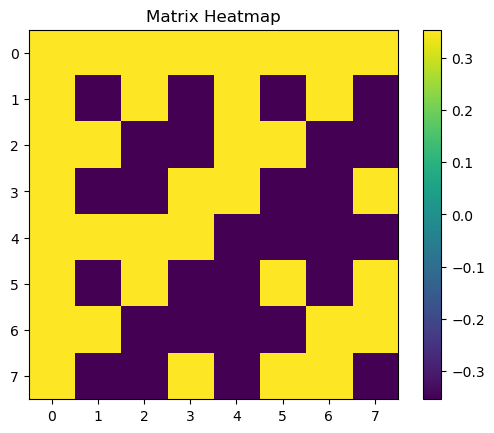

In [43]:

H_single = (1/np.sqrt(2)) * np.array([[1,  1],
                                           [1, -1]], dtype=complex)
H_3q = np.kron(np.kron(H_single, H_single),H_single)
print(np.round(H_3q,1))

import matplotlib.pyplot as plt

plt.imshow(np.real(H_3q), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Matrix Heatmap")
plt.show()
